## Introduction:
The goal of this notebook is to take a dataframe consisting of routes travelled across an environment by a number of subjects and to convert the points data into detailed information about use of this environment on a block by block basis.

We will output this data in two of forms:
1. A dataframe with a number of columns containing characteristics for each block of the environment.
2. A network graph containing above information plus data about how much movement there is between any two blocks.

These files can then be further worked on to derive new information and  used in machine learning workflows or other processes.

## Start:
First we import the required modules and set matplotlib to display images in-line throughout the document.

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from datetime import datetime
import networkx as nx
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,10]

Next we'll create a number of parameters/variables for use throughout the script

In [2]:
# Get the current date and time for unique naming of outputs.
current_time = datetime.now().strftime('%Y-%m-%d %H%M%S')

# Create colours for use in visualisations below.
colours = np.random.randint(0, 255, (301, 3))
newColours = []
for c in colours:
    newColours.append((c[0]/255, c[1]/255, c[2]/255,))

We'll now import the route data from a pickle file, convert to a dataframe and see how many route are contained in it.

In [37]:
routedata = "Crossing 02"

df = pd.read_pickle(routedata+"_routelist.pkl")
df = df.to_frame()
print('Number of routes recorded:', len(df))

Number of routes recorded: 485


We now want to take these original routes which are 15 seconds each and break them down into segments that correspond with a grid laid over the space.<br> 
First though, we'll record in which 15 second period the route was recorded as the information will be lost after we reformat.

In [38]:
# create a column that notes in which generation the route was recorded
df['Generation'] = df.index
df['Generation'] = df['Generation'].apply(lambda a: int(a.split(':')[0]))

To split the environment up according to a grid first we need to locate its extremities.

In [39]:
# Extract all the points visited into a master list
allPointsVisited = [y for x in df['Points Visited'] for y in x]
allPointsVisited = list(filter(None, allPointsVisited))
print('Total number of points recorded:', len(allPointsVisited))

Total number of points recorded: 14057


In [40]:
import operator
trimpercent = int((len(allPointsVisited)/100)*1)
trimmedPoints = (sorted(allPointsVisited, 
                       key=operator.itemgetter(0)))[trimpercent:len(allPointsVisited)-trimpercent]
trimmedPoints = (sorted(trimmedPoints, 
                       key=operator.itemgetter(1)))[trimpercent:len(trimmedPoints)-trimpercent]

print('% of points maintained:', ((len(trimmedPoints)/len(allPointsVisited))*100), "%")

% of points maintained: 96.01621967702924 %


In [41]:
allXCoords = []
allYCoords = []
for point in allPointsVisited:
    try:
        allXCoords.append(point[0])
        allYCoords.append(point[1])
    except TypeError:
        continue
        
mostXCoords = []
mostYCoords = []
for point in trimmedPoints:
    try:
        mostXCoords.append(point[0])
        mostYCoords.append(point[1])
    except TypeError:
        continue

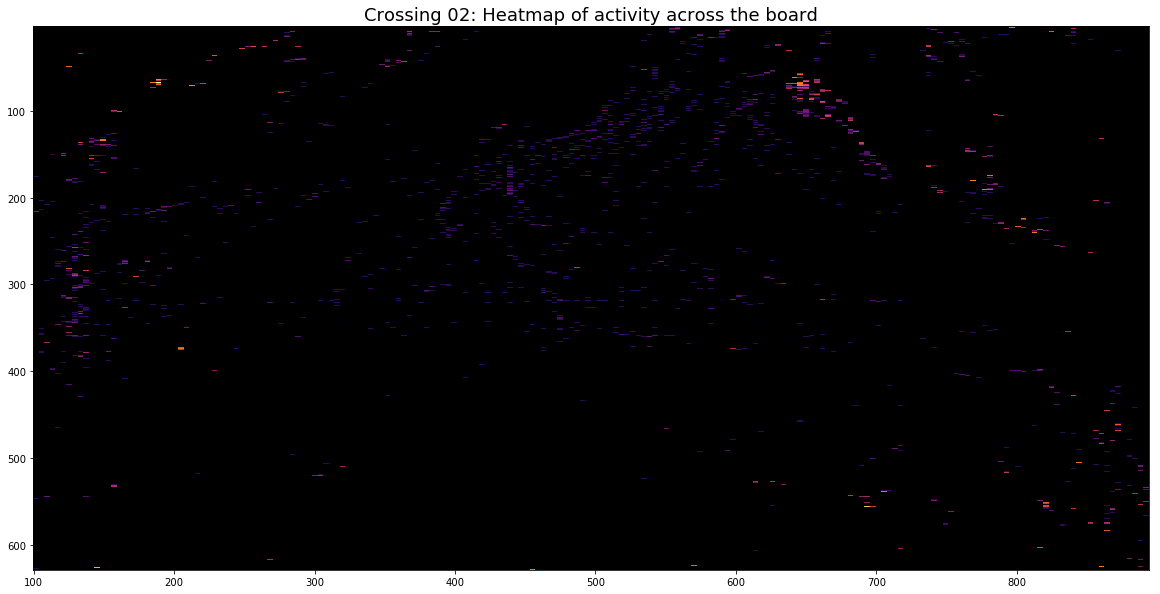

In [42]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=1, figsize=(20,10))

#axs[0].hist2d(allXCoords,allYCoords, bins=[200,600], norm=LogNorm(), cmap='inferno')
#axs[0].set_facecolor('black')
#axs[0].invert_yaxis()
#axs[0].set_title(routedata+": Heatmap of activity across the board", fontsize=18)

axs.hist2d(mostXCoords,mostYCoords, bins=[200,600], norm=LogNorm(), cmap='inferno')
axs.set_facecolor('black')
axs.invert_yaxis()
axs.set_title(routedata+": Heatmap of activity across the board", fontsize=18)


plt.savefig(routedata+'_activity.png', bbox_inches='tight')

plt.show()

In [43]:
# Get the edge points and the point that is a the centre of the recorded board
maxX = max(mostXCoords)
minX = min(mostXCoords)
maxY = max(mostYCoords)
minY = min(mostYCoords)
middleX = (maxX - minX) / 2
middleY = (maxY - minY) / 2
centrepoint = (middleX, middleY)

# Numbers of blocks in each direction
XstepNo = 30
YstepNo = 10

# These variables will be the lenght and width of our grid squares
x_step = (maxX-minX)/XstepNo
y_step = (maxY-minY)/YstepNo
print("Block length in pixels:", x_step);
print("Block width in pixels:", y_step)

Block length in pixels: 26.490285237630207
Block width in pixels: 62.66196975708008


We'll now create a number of functions which: 
1. Take a list of points along a route
2. Decide which block they each occur on
3. Split the route into smaller routes identifying which block they occur on.

**This process ends up normalising routes on a block level which may affect measurements on speed etc later on**

In [44]:
testlist = (df["Points Visited"][0])

In [45]:
# scales a point into a simpler range corresponding to block number
def reduce_range(pt):
    x = pt[0]
    y = pt[1]
    return [(x-minX)/x_step, (y-minY)/y_step]

In [46]:
# uses the above function and applys it to a list
# converts a list of points into a simpler range corresponding to block number
def lst_reduce_range(lst):
    lst =list(filter(None,lst))
    outlist = []
    deadlist = []
    for p in lst:
        if p[0]> maxX or p[0]< minX or p[1]> maxY or p[1]< minY:
            deadlist.append(reduce_range(p))         
        else:
            try:
                outlist.append(reduce_range(p))
            except TypeError:
                continue
    return outlist

In [47]:
# scales a point into an int in a range corresponding to block number
def block_assigner(pt):
    x = pt[0]
    y = pt[1]
    return [int((x-minX)//x_step), int((y-minY)//y_step)]

In [48]:
# uses the above function and applys it to a list
# converts a list of points into an int in a range corresponding to block number
def lst_block_assigner(lst):
    lst =list(filter(None,lst))
    outlist = []
    deadlist = []
    for p in lst:
        if p[0]> maxX or p[0]< minX or p[1]> maxY or p[1]< minY:
            deadlist.append(block_assigner(p))
        else:
            try:
                outlist.append(block_assigner(p))
            except TypeError:
                continue
    return outlist

In [49]:
# find indices on which to split a list based on points being on different blocks
# to be carried out on a list that has already been simplified into block assignment
def splitting_indices(lst):
    initialise = lst[0]
    splitting_ind = []
    for i, v in enumerate(lst):
        if v[0] != initialise[0]:
            splitting_ind.append(i)
            initialise = v
        elif v[1] != initialise[1]:
            splitting_ind.append(i)
            initialise = v
        else:
            initialise = v
    return splitting_ind

In [50]:
# given a list of points, simplify to block range, simplify further to an individual block...
# then split the original list into separate lists according to which block they occur on
def list_splitter(lst):
    blockrange = lst_reduce_range(lst)
    block_ids = lst_block_assigner(lst)
    if len(block_ids) >= 1:
        splits = splitting_indices(block_ids)
        outlist = []
        startindex = 0
        # either 'blockrange' or 'lst' can be passed to the loop below
        # blockrange returns numbers in lower range, 'lst' in original format
        for i in splits:
            outlist.append(((block_ids[startindex]), blockrange[startindex:i]))
            startindex = i
        outlist.append(((block_ids[startindex]), blockrange[startindex:]))
        return outlist

Now that these functions are created, splitting the original routes into smaller segments and idetifying on which block each of these occurred is a single line in Pandas.

In [51]:
df['Split Points'] = df['Points Visited'].map(lambda a: list_splitter(a))
print(df.sample(5))


                                          Points Visited  Generation  \
3:8    [[563.1831665039062, 188.3328094482422], [563....           3   
12:4   [[127.90491485595703, 307.2318115234375], [109...          12   
30:4   [[360.7024230957031, 367.8855895996094], [357....          30   
1:11   [[646.1737670898438, 69.04560089111328], [646....           1   
29:10  [[717.7072143554688, 224.99717712402344], [702...          29   

                                            Split Points  
3:8    [([17, 2], [[17.49705637377352, 2.968664933357...  
12:4   [([1, 4], [[1.0654382260903092, 4.866131650987...  
30:4   [([9, 5], [[9.853471505137474, 5.8340836370374...  
1:11   [([20, 1], [[20.629925644205045, 1.06500296710...  
29:10  [([23, 3], [[23.33029095261666, 3.553778484972...  


Shortly we will create a new dataframe where each of these route segments has it's own row and can be studied individually.

Before we discard the original dataframe however, we must extract data about how frequently subjects cross the boundaries between blocks. This will allow us to carry out network analysis on the environment.

First we create and deploy a function to log the block ids for every border crossing that occurs and save it to a list called 'pair_master'.

In [52]:
# function to log when an ant travels between two blocks
pair_master = [] #store for pairs of block
blockIDs = [] #store of all blocks in board
def connection_counter(lst):
    block_ids = lst_block_assigner(lst)
    for i in block_ids:
        blockIDs.append(str(i))
    if len(block_ids) >= 1:
        splits = splitting_indices(block_ids)
        for i in splits:
            pair_master.append((str(block_ids[i-1]), str(block_ids[i])))


df['Points Visited'].map(lambda a: connection_counter(a))
print("Total number of connections between blocks:", len(pair_master))

Total number of connections between blocks: 2918


We'll now take that master list of connections and create a dictionary that counts how many connections there are between any two blocks.

In [53]:
edge_weights = {}
for a in pair_master:
    try:
        edge_weights[a] += 1
    except KeyError:
        edge_weights[a] = 1

print("Number of fulfilled connections between blocks:", len(edge_weights))
print('Most connections:', max(edge_weights.values()))
print('Least connections:', min(edge_weights.values()))

Number of fulfilled connections between blocks: 798
Most connections: 33
Least connections: 1


We can now construct our network graph object and add additional characteristics about each of the blocks as they are created further down.

In [54]:
# Create the graph object and add both nodes and the numbers of routes between them as weights
blocksIDs = set(blockIDs)

G = nx.DiGraph()
G.add_nodes_from(blocksIDs)
G.add_edges_from(edge_weights)

# we can now add how many connections have occured to each edge
for pair in edge_weights:
    G[pair[0]][pair[1]]["weight"] = edge_weights[pair]

Let's see what this graph looks like. <br>
This is a pretty rough representation and we can use other software to produce clearer diagrams later on.

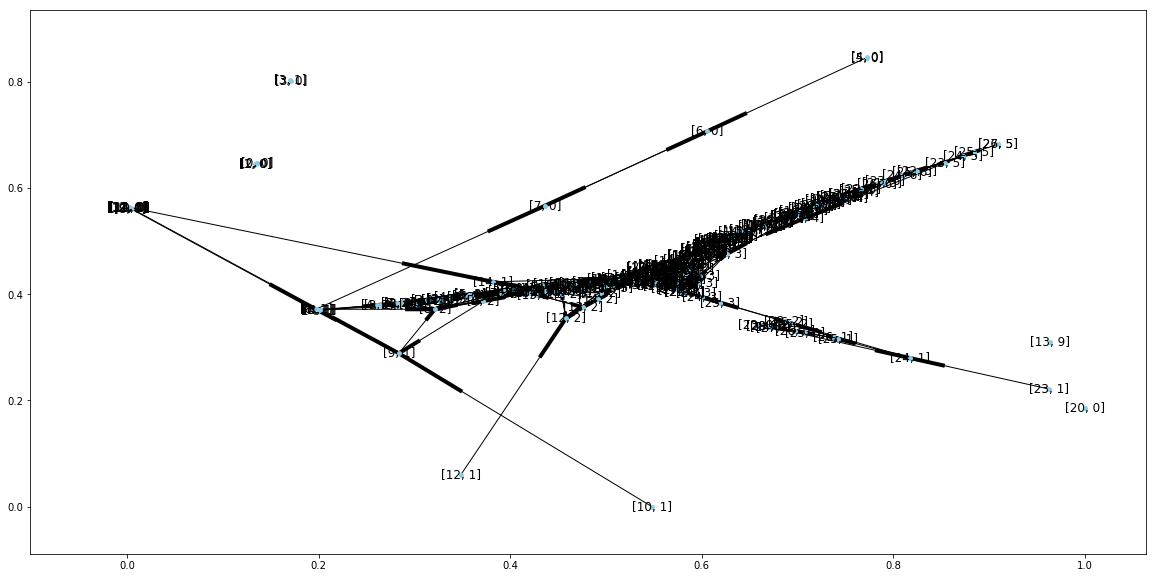

In [55]:
# creating a copy and removing a pair of nodes that are not working in the example file
G1 = G.copy()
G1.remove_nodes_from(["[19, 0]", "[19, 1]"])

pos = nx.fruchterman_reingold_layout(G1,k=0.001, iterations=100, scale=1)
nx.draw_networkx(G1, with_labels=True, node_size=15, node_color="skyblue", pos=pos)
plt.show()

The below functions will allow us to extract statistical data from a dataframe and load it into our network graph. We will deploy them as and when new data columns are created.

In [56]:
# Function to convert a column of features about activity into
# the sum of said feature appearances on a per block bases
def sum_column_to_attribute(dataframe, column, graph):
    group = dataframe.groupby(['Block']).sum()[column]
    groupdict = group.to_dict()
    for k in groupdict:
        groupdict[k] = float(groupdict[k])
    nx.set_node_attributes(graph, "sum_"+column, groupdict)

In [57]:
# Function to convert a column of features about activity into
# the mean of said feature appearances on a per block bases
def mean_column_to_attribute(dataframe, column, graph):
    group = dataframe.groupby(['Block']).mean()[column]
    groupdict = group.to_dict()
    for k in groupdict:
        groupdict[k] = float(groupdict[k])
    nx.set_node_attributes(graph, "mean_"+column, groupdict)

In [58]:
# Function to convert a column of features about activity into
# the mode of said feature appearances on a per block bases
def mode_column_to_attribute(dataframe, column, graph):
    group = dataframe.groupby(['Block']).agg(lambda x: stats.mode(x)[0][0])[column]
    groupdict = group.to_dict()
    for k in groupdict:
        groupdict[k] = float(groupdict[k])
    nx.set_node_attributes(graph, "mode_"+column, groupdict)

**Getting back to the creation of our new dataframe.**

First we extract the block id, points visited and generation created for each route segment into a list. We will then use this list to create the new dataframe.

In [59]:
constructorList = []
for routes, generation in list(zip(df['Split Points'].tolist(), df['Generation'].tolist())):
    if routes != None:
        for route in routes:
            constructorList.append((route[0], route[1], generation))

newDF = pd.DataFrame(constructorList, columns=['Block', 'Points', 'Generation'])
print('Number of original routes recorded:', len(df))
print("Number of new route segments:", len(newDF))
newDF.sample(5)

Number of original routes recorded: 485
Number of new route segments: 3402


,Block,Points,Generation
2810,"[4, 5]","[[4.740935931440448, 5.3071255270018804]]",28
1133,"[2, 4]","[[2.6150627414220877, 4.075161930513158], [2.3...",13
2453,"[11, 5]","[[11.67628790127572, 5.4423332395050386], [11....",26
2654,"[3, 5]","[[3.9911136319213427, 5.073948558872035], [3.3...",27
2011,"[17, 7]","[[17.868834580532784, 7.830950716013701]]",22


So far so good but sometimes an ant will only graze the corner of a block and leave one point. We should remove those 'routes'.

In [60]:
newDF = newDF[newDF['Points'].str.len() > 1]
print("Route segments > 1 point long:", len(newDF))

Route segments > 1 point long: 2326


** Currently about 10% of routes are lost at this step. Is the cleaning function performing as expected?**

We will next create a number of columns displaying some basic characteristics about each route.<br>
By splitting the block name we can get its row and column and by taking the first and last point in each list we can get a start points and endpoint.

In [61]:
# create a column each for the row and column a block sits in
newDF['Block Column'] = newDF['Block'].map(lambda a: a[0])
newDF['Block Row'] = newDF['Block'].map(lambda a: a[1])

# convert the block name into a string
newDF['Block'] = newDF['Block'].map(lambda a: str(a))

# get the start and end point for the recorded period
newDF['Start Point'] = newDF['Points'].map(lambda a: a[0])
newDF['End Point'] = newDF['Points'].map(lambda a: a[len(a)-1])
newDF = newDF[pd.notnull(newDF['End Point'])]

The next operations will convert our points list into data about the time spent on a block, the distance travelled and speed.

We will also create a measure of the shortest distance from the start point to the end point called the 'Vector Distance' from which we can later derive measurements of direction and efficiency.

In [62]:
# create a column for time spent on block based on frame rate of 30fps
newDF['Time Spent'] = newDF['Points'].map(lambda a: len(a)/30)
# as our original routes were just 15sec long we can discard any longer ones as corrupted
newDF = newDF[newDF['Time Spent'] < 14.9]
# we will also add this date to our nodes in the network graph 'G' in both sum and mean form
sum_column_to_attribute(newDF, 'Time Spent', G)
mean_column_to_attribute(newDF, 'Time Spent', G)

In [63]:
# these two functions measure distance between two points and the length along a series of points respectively
def distance(p0, p1):
    try:
        return np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    except TypeError:
        return[]


def length_travelled(lst):
    route_len = 0
    for ind, p in enumerate(lst):
        if ind == 0:
            p_old = p
        else:
            p_old = p_old
        route_len += distance(p, p_old)
        p_old = p
    return route_len


# we use the first function to get the distance from the start point to the end point...
newDF['Vector Distance'] = newDF[['Start Point', 'End Point']].apply(lambda a: distance(*a), axis=1)
mean_column_to_attribute(newDF, 'Vector Distance', G) # adding to our network graph

# and the second to get the length of the entire route
newDF['Distance Travelled'] = newDF['Points'].map(lambda a: length_travelled(a))
sum_column_to_attribute(newDF, 'Distance Travelled', G) # adding to our network graph

In [64]:
# This operation makes a measurement of the speed in which the distance was covered
newDF['Speed'] = newDF['Distance Travelled'].map(lambda a: a/30)
# Once again a value of >15 indicates an error in the data
newDF = newDF[newDF['Speed'] <= 15]
mean_column_to_attribute(newDF, 'Speed', G) # adding to our network graph

The next charateristics we want to add is about the efficiency of the route. This metric may indicate where subjects congregate/linger.<br>
The measure of efficiency we will use is the distance travelled divided by the length from start point to end point.

In [65]:
newDF['Efficiency'] = newDF['Distance Travelled']/(newDF['Vector Distance'])
# if un-commented, the below line should be tailored to a reading of the particular data
# newDF = newDF[newDF['Efficiency'] <= 21]
mean_column_to_attribute(newDF, 'Efficiency', G) # adding to our network graph

The final set of columns we'll add to the column relate to the direction of travel. We will use only the start point and end point for this metric.

In [66]:
# function to compute the angle with regards to the x axis
def angle_wrt_x(pt1, pt2):
    ax, ay = pt1
    bx, by = pt2
    return np.rad2deg(math.atan2(by-ay, bx-ax) % (2*np.pi))

# the first column added is the exact angle of the vector route
newDF['Vector Angle'] = newDF[['Start Point', 'End Point']].apply(lambda a: angle_wrt_x(*a), axis=1)

# the second column is the angle rounded to the nearest 22.5 degrees
newDF['General Direction'] = newDF['Vector Angle'].apply(lambda a: (a//22.5)*22.5)
mode_column_to_attribute(newDF, 'General Direction', G) # adding the most common general direction for to our network graph

**We have now expanded our original list of points into a dataframe with 14 separate columns.**<br>

In [67]:
newDF.sample(5)

,Block,Points,Generation,Block Column,Block Row,Start Point,End Point,Time Spent,Vector Distance,Distance Travelled,Speed,Efficiency,Vector Angle,General Direction
2518,"[8, 2]","[[8.07329516021076, 2.8968605370917606], [8.33...",26,8,2,"[8.07329516021076, 2.8968605370917606]","[8.960274582283867, 2.764363086058582]",0.166667,0.896821,0.897147,0.029905,1.000363,351.503950,337.5
1642,"[25, 8]","[[25.806395374065755, 8.63407010277577], [25.9...",19,25,8,"[25.806395374065755, 8.63407010277577]","[25.670340743312185, 8.557662645183294]",0.100000,0.156042,0.450930,0.015031,2.889810,209.318303,202.5
601,"[15, 2]","[[15.040071026431002, 2.2307688533294034], [15...",8,15,2,"[15.040071026431002, 2.2307688533294034]","[15.712770741227011, 2.0140606806601307]",0.200000,0.706744,0.707308,0.023577,1.000798,342.143812,337.5
2872,"[15, 2]","[[15.172322809291959, 2.3242046913652006], [15...",28,15,2,"[15.172322809291959, 2.3242046913652006]","[15.888270846637669, 2.2276085861813897]",0.100000,0.722435,0.722469,0.024082,1.000047,352.316023,337.5
302,"[3, 4]","[[3.090628973300191, 4.4806389622830105], [3.5...",4,3,4,"[3.090628973300191, 4.4806389622830105]","[3.5156228579459863, 4.332543749506969]",0.066667,0.450058,0.450058,0.015002,1.000000,340.788376,337.5


To finish up we will save it as a .CSV file for use in machine learning processes or to produce visualisations.

In [68]:
outfile1 = routedata+"_DF.csv"
newDF.to_csv(outfile1)

newDF.info();
print()
newDF.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 1 to 3401
Data columns (total 14 columns):
Block                 2326 non-null object
Points                2326 non-null object
Generation            2326 non-null int64
Block Column          2326 non-null int64
Block Row             2326 non-null int64
Start Point           2326 non-null object
End Point             2326 non-null object
Time Spent            2326 non-null float64
Vector Distance       2326 non-null float64
Distance Travelled    2326 non-null float64
Speed                 2326 non-null float64
Efficiency            2309 non-null float64
Vector Angle          2326 non-null float64
General Direction     2326 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 352.6+ KB



,Generation,Block Column,Block Row,Time Spent,Vector Distance,Distance Travelled,Speed,Efficiency,Vector Angle,General Direction
count,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2309.000000,2326.000000,2326.000000
mean,18.351247,13.245486,3.847377,0.178045,0.509127,0.556609,0.018554,1.577960,212.881660,201.136071
std,9.026128,7.692052,2.107112,0.186427,0.278509,0.321357,0.010712,10.026799,113.862658,113.369017
min,1.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,11.000000,7.000000,2.000000,0.066667,0.299053,0.338122,0.011271,1.000000,162.074481,157.500000
50%,19.000000,13.000000,4.000000,0.100000,0.526386,0.557480,0.018583,1.000229,181.579756,180.000000
75%,26.000000,19.000000,5.000000,0.200000,0.730472,0.763660,0.025455,1.013012,333.214797,315.000000
max,32.000000,29.000000,9.000000,1.000000,1.258861,3.477965,0.115932,468.692485,359.946919,337.500000


Let's also see what our network graph is looking like now. <br>
It is now possible to adjust the size of each node based on one of our added qualities.

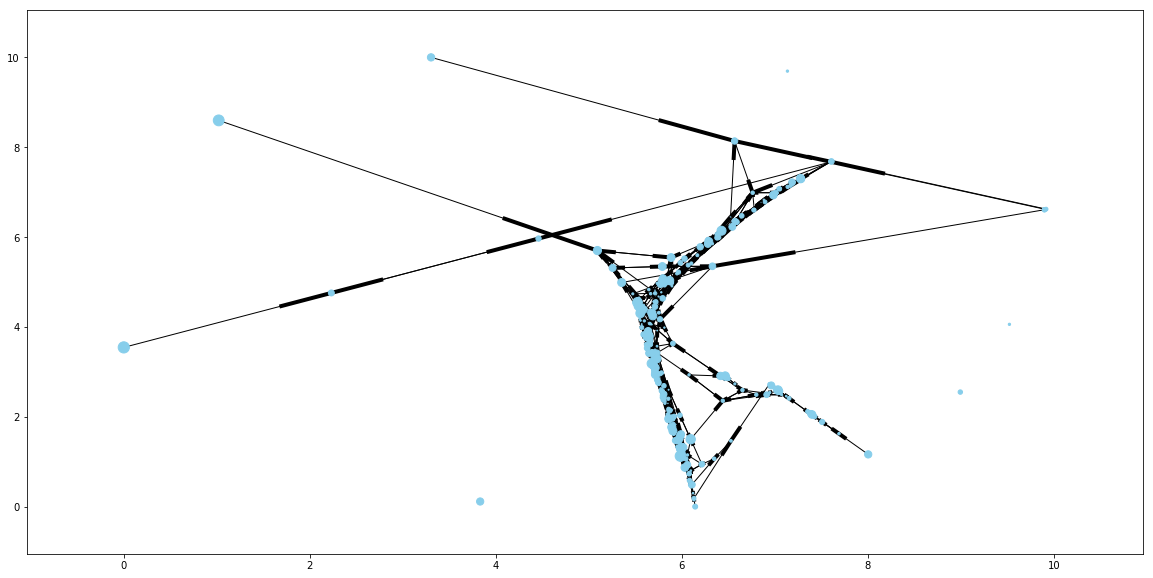

In [69]:
# creating a copy and removing a pair of nodes that are not working in example
G1 = G.copy()
G1.remove_nodes_from(["[19, 0]", "[19, 1]"])

pos = nx.fruchterman_reingold_layout(G1,k=0.001,iterations=500, scale=10)
node_sizes = [5*a for a in nx.get_node_attributes(G1, 'sum_Distance Travelled').values()]
nx.draw_networkx(G1, with_labels=False, node_size=node_sizes, node_color="skyblue", pos=pos)
plt.show()

We'll save the nextowrk graph out to the same place as the dataframe for use in subsequent processing.

In [70]:
outfile2 = routedata+"_network.gexf"
nx.write_gexf(G, outfile2)